<a href="https://colab.research.google.com/github/ahmad-AI7/Langchain-Groq-rag-application/blob/main/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain_groq langchain-huggingface sentence-transformers langchain_chroma

In [ ]:
pip install -U langchain langchain-openai

In [5]:
 import getpass
 import os

 os.environ["Langchain_Tracking_V2"] = 'true'
 os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

··········


In [6]:
import getpass
import os

if not os.environ.get("GROQ_API_KEY"):
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter Api key for Groq : ")

from langchain_groq import ChatGroq

llm = ChatGroq(model = "llama3-8b-8192")

Enter Api key for Groq : ··········


In [9]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function= embeddings)

In [11]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START , StateGraph
from typing_extensions import List , TypedDict

#load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths= ("https://lilianweng.github.io/posts/2023-06-23-agent/" , ),
    bs_kwargs=dict(
        parse_only = bs4.SoupStrainer(
            class_ = ("post-content" , "post-tittle" , "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size= 1000,
    chunk_overlap= 200,)

all_splits = text_splitter.split_documents(docs)

#Index chunks
_ = vector_store.add_documents(documents = all_splits)

#index done. ----------------------------------------------------------


#Define prompt for question answering
prompt = hub.pull("rlm/rag-prompt")

#define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer : str

#define application step

def retrieve(state: State):
  retrieved_docs = vector_store.similarity_search(state["question"])
  return {"context": retrieved_docs}


def generate(state : State) :
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messeges = prompt.invoke(    {"question": state["question"] , "context" : docs_content})
  response = llm.invoke(messeges)
  return {"answer": response.content}


#compile the application and test

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START , 'retrieve')
graph_builder.add_edge('retrieve' , 'generate')
graph = graph_builder.compile()






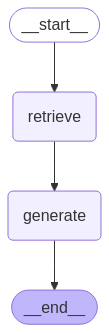

In [12]:
from IPython.display import display , Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
response = graph.invoke({"question" : " What is task Decomposition?"})
print(response['answer'])

Task Decomposition is a technique used to break down complex tasks into smaller, manageable steps. This is done by instructing the model to think step by step, utilizing more test-time computation to decompose hard tasks into simpler steps. The goal is to transform big tasks into multiple manageable tasks and provide insight into the model's thinking process.
